In [20]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [21]:
import numpy as np 
import scipy.special
import scipy.fft
from operators.SW_sqrt import solve_poisson_equation_two_stream, psi_ln_sw, linear_2_two_stream, mass, momentum, energy_k

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib.pylab as pl
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Bump-on-tail Instability SW square-root

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 101
# number of spectral expansions
Nv = 100
# epsilon displacement in initial electron distribution
epsilon = 0.03
# Velocity scaling of electron and ion
alpha_e1 = np.sqrt(2)
alpha_e2 = 1 / np.sqrt(2)
alpha_i = np.sqrt(2 / 1863)
# x grid is from 0 to L
L = 20 * np.pi 
# spacial spacing dx = x[i+1] - x[i]
dx = L / (Nx - 1)
# final time
T = 20
# velocity scaling
u_e1 = 0
u_e2 = 4.5
u_i = 0
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1863
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1
# delta for initial condition
delta1 = 9 / 10
delta2 = 1 / 10

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-8, 8, int(1e5))
# spatial grid
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]

In [6]:
# initial condition of the first expansion coefficient
C_0e1 = np.sqrt(delta1 * (1 + epsilon * np.cos(0.3 * x)) / alpha_e1)
C_0e2 = np.sqrt(delta2 * (1 + epsilon * np.cos(0.3 * x)) / alpha_e2)

In [7]:
# initialize states (electrons type 1 and 2)
states_e1 = np.zeros((Nv, Nx - 1))
states_e2 = np.zeros((Nv, Nx - 1))
states_i = np.zeros((Nv, Nx - 1))

In [8]:
# initialize the expansion coefficients
states_e1[0, :] = C_0e1[:-1]
states_e2[0, :] = C_0e2[:-1]
states_i[0, :] = np.sqrt(np.ones(Nx - 1) / alpha_i)

# initial condition of the semi-discretized ODE
y0 = np.zeros((2 * Nv) * (Nx - 1) + 2)
y0[:(Nx - 1) * Nv] = states_e1.flatten("C")
y0[Nv * (Nx - 1): 2 * Nv * (Nx - 1)] = states_e2.flatten("C")

In [9]:
# the distribution function of electrons and protons for plotting purposes
f_0e1 = np.outer(C_0e1, psi_ln_sw((v-u_e1)/alpha_e1, n=0))
f_0e2 = np.outer(C_0e2, psi_ln_sw((v-u_e2)/alpha_e2, n=0))

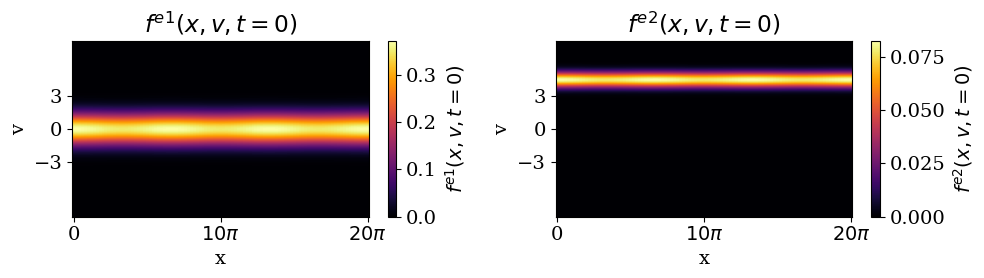

In [10]:
# plot initial condition 
fig, ax = plt.subplots(ncols=2, sharey=False, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e1**2).T, cmap="inferno", vmin=0, vmax=np.max(f_0e1**2))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, 10*np.pi, 20*np.pi])
ax[0].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e1}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e1}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0e2**2).T, cmap="inferno", vmin=0, vmax=np.max(f_0e2**2))
ax[1].set_xticks([0, 10*np.pi, 20*np.pi])
ax[1].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[1].set_xlabel("x")
ax[1].set_ylabel("v")
ax[1].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e2}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{e2}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/bump_on_tail/initial_condition.png", dpi=600)

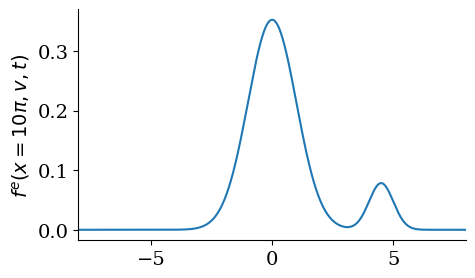

In [11]:
# plot vertical slice of the electron initial condition 
fig, ax = plt.subplots(figsize=(5, 3))
_ = plt.plot(v, (f_0e1[55, :])**2+ (f_0e2[55, :])**2)
_ = ax.set_xlim(v[0], v[-1])
_ = ax.set_ylabel("$f^{e}(x= 10\pi, v, t)$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [12]:
# read simulation data 
sol_midpoint_u = np.load("../data/SW_sqrt/bump_on_tail/sol_midpoint_u_" + str(Nv) + ".npy")
sol_midpoint_t = np.load("../data/SW_sqrt/bump_on_tail/sol_midpoint_t_" + str(Nv) + ".npy")

# print simulation data shape 
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20002, 2001)
(2001,)


In [13]:
# initialize electric field
E_midpoint = np.zeros((Nx, len(sol_midpoint_t)))

In [14]:
# initialize the states for implicit midpoint
state_e1_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    for jj in range(0, Nv):
        # unwind the flattening in order to solve the Vlasov-Poisson system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv*(Nx-1) + jj*(Nx-1): Nv*(Nx-1) + (jj+1)*(Nx-1), ii]
        # static/background ions 
        state_i_midpoint[0, :, ii] = np.sqrt(np.ones(Nx-1) / alpha_i)
    
    E_midpoint[:-1, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii], 
                                           state_e2=state_e2_midpoint[:, :, ii],
                                           state_i=state_i_midpoint[:, :, ii], 
                                           alpha_e1=alpha_e1, 
                                           alpha_e2=alpha_e2, 
                                           alpha_i=alpha_i, 
                                           dx=dx, L=L)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

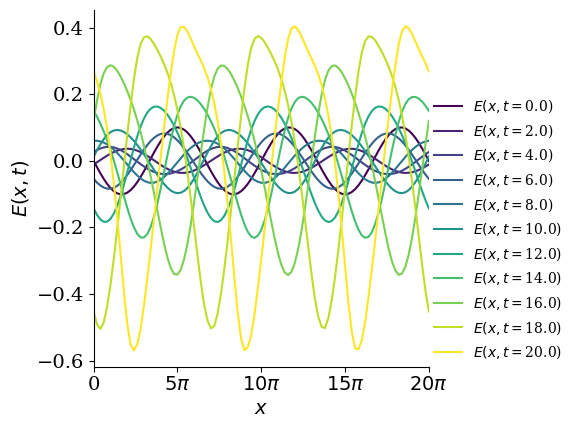

In [15]:
# plot electric field evolution 
fig, ax = plt.subplots(figsize=(6, 4.5))
colors = pl.cm.viridis(np.linspace(0, 1, len(sol_midpoint_t)//200 + 1))

for kk, ii in enumerate(range(0, len(sol_midpoint_t), 200)):
    _ = plt.plot(x, E_midpoint[:, ii], c=colors[kk], label=r"$E(x, t=$" + str(round(sol_midpoint_t[ii], 2)) + ")")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=10, loc=(1, 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend.get_frame().set_alpha(0)
ax.set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
ax.set_xlim(0, 20*np.pi)
ax.set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
ax.set_xlabel("$x$")
ax.set_ylabel("$E(x, t)$")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/bump_on_tail/electric_field.png", dpi=600)

In [16]:
# save electric field
np.save("../data/SW_sqrt/bump_on_tail/sol_midpoint_e_" + str(Nv) + ".npy", E_midpoint)

In [17]:
# compute growth rate 
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

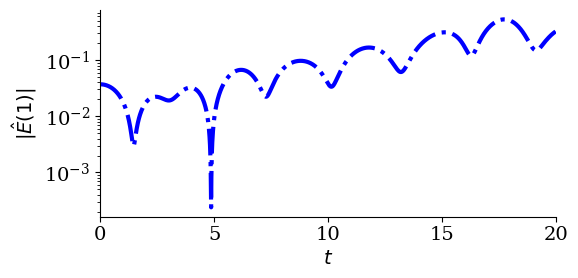

In [18]:
# plot growth grate 
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-.", c="blue", linewidth=3)
ax.set_xlim(0, 20)
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/bump_on_tail/bump_on_tail_electric_field.png", dpi=600)

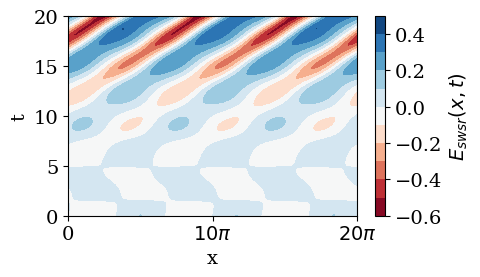

In [19]:
# plot electric field
fig, ax = plt.subplots(figsize=(5, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=10)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E_{swsr}(x, t)$", rotation=90)
cbar.ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4])
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_xticks([0, 10*np.pi, 20*np.pi])
ax.set_xticklabels([r"0", r"$10\pi$",  r"$20\pi$"])
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/bump_on_tail/bump_on_tail_electric_field_evolution.png", dpi=600)

In [23]:
Nv

100

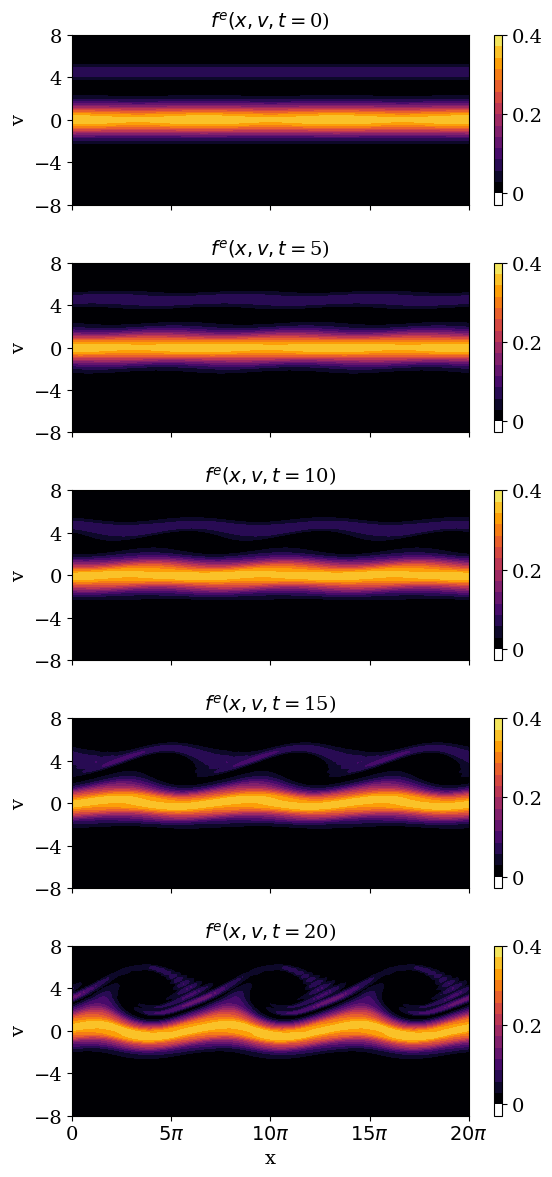

In [26]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(6, 12))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)//4))):
    distribution1 = np.zeros((Nx, len(v)))
    distribution2 = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution1 += np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj)) 
        distribution2 += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj)) 
    levels = np.append(-0.1, np.linspace(0, 0.4, 15))
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution1**2 + distribution2**2).T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
    ax[tt].set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_yticks([0, 0.2, 0.4])
    cbar.ax.set_yticklabels(["0", "0.2", "0.4"])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=14)
    ax[tt].set_yticks([-8, -4, 0, 4, 8])
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/bump_on_tail/bump_on_tail_evolution_SW_sqrt_" + str(Nv) + ".png", dpi=600)

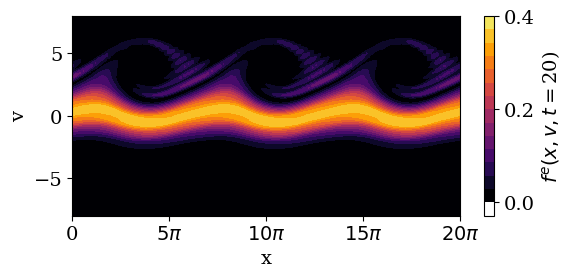

In [21]:
fig, ax = plt.subplots(figsize=(6, 3))
ii = -1
distribution1 = np.zeros((Nx, len(v)))
distribution2 = np.zeros((Nx, len(v)))
for jj in range(Nv):
    distribution1 += np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))
    distribution2 += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj)) 
levels = np.append(-0.1, np.linspace(0, 0.4, 15))
colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
pos = ax.contourf(x, v, (distribution1**2 + distribution2**2).T, levels=levels, colors=np.append(["w"], colors))
ax.set_xlabel("x")
ax.set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi,  20*np.pi])
ax.set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
cbar.ax.set_yticks([0, 0.2, 0.4])
plt.tight_layout()

In [23]:
# save distribution 
np.save("../data/SW_sqrt/bump_on_tail/distribution_20_" + str(Nv), distribution1**2 + distribution2**2)

# conservation laws: mass, momentum, and energy

### mass conservation

In [24]:
# compute mass evolution 
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv)+\
                        mass(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv)+\
                        mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

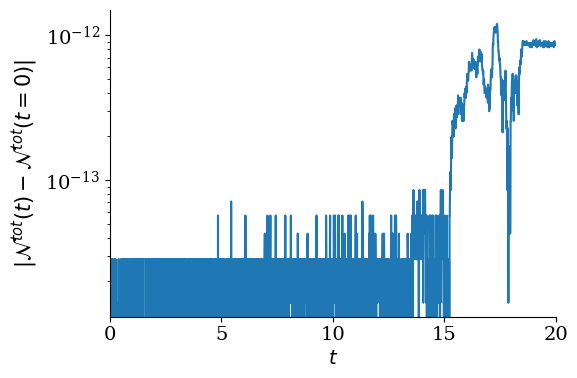

In [25]:
# plot mass evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [26]:
# momentum evolution 
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv, u_s=u_e1, m_s=m_e1)\
                           +momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv, u_s=u_e2, m_s=m_e2)\
                           +momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, u_s=u_i, m_s=m_i)

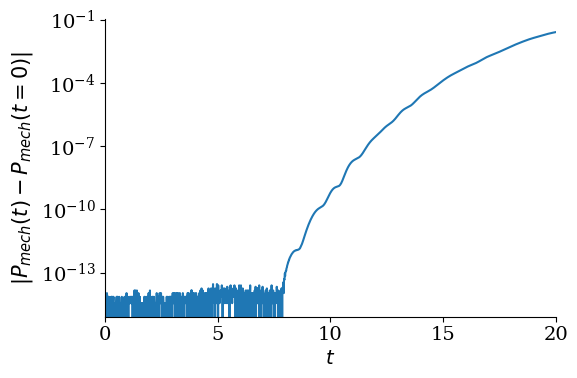

In [27]:
# plot momentum evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [28]:
# compute kinetic + potential energy evolution 
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = energy_k(state=state_e1_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_e1, m_s=m_e1, dx=dx, u_s=u_e1)\
                           +energy_k(state=state_e2_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_e2, m_s=m_e2, dx=dx, u_s=u_e2)\
                           +energy_k(state=state_i_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_i, m_s=m_i, dx=dx, u_s=u_i)
    
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:-1, ii])**2)

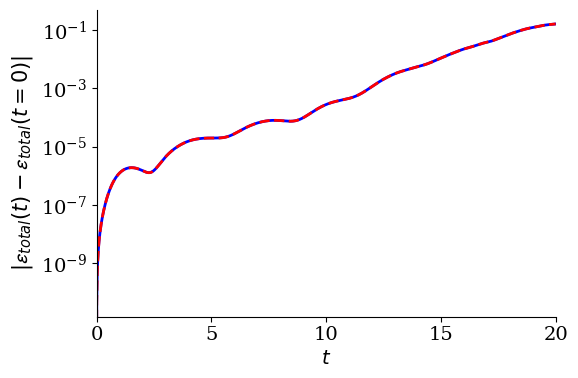

In [29]:
# plot energy evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-", color="blue", linewidth=2, label="numerical")
ax.plot(sol_midpoint_t, sol_midpoint_u[-1, :], ls="--", color="red", linewidth=2, label="analytic")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

In [30]:
# save kinetic and potential energy results
np.save("../data/SW_sqrt/bump_on_tail/kinetic_energy_" + str(Nv), energy_k_midpoint)
np.save("../data/SW_sqrt/bump_on_tail/potential_energy_" + str(Nv), energy_p_midpoint)

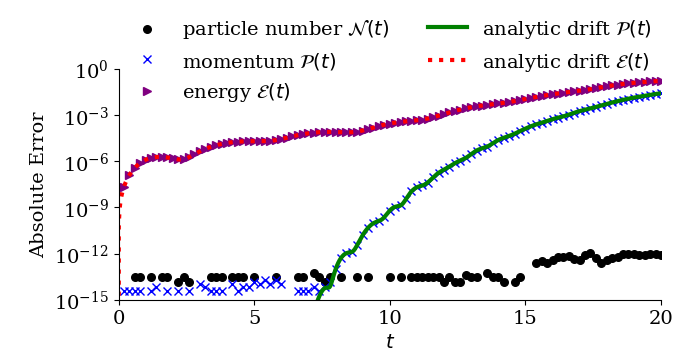

In [31]:
# plot overall conservation properties
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))

ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.set_ylim(10**-15, 10**0)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 5, 10, 15, 20])
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW_sqrt/bump_on_tail/conservation_" + str(Nv) + "_bump_on_tail_SW_sqrt.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)